# Goal: 
Predict if a passenger will survive or not.

# 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

# 2. Collecting the data

- data to train the model

In [2]:
train = pd.read_csv('dataset/train.csv')

- data to predict

In [3]:
test = pd.read_csv('dataset/test.csv')

# 3. Exploratory data analysis

In [4]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


### Data Dictionary

- Survived: <br>
    0 = No; 1 = Yes
- pclass (Ticket class): <br> 
    1 = 1st; 2 = 2nd; 3 = 3rd
- sibsp: # of siblings / spouses aboard the Titanic
- parch: # of parents / children aboard the Titanic
- fare: Passenger fare
- ticket: Ticket number
- cabin: Cabin number
- embarked (Port of Embarkation): <br>
    C = Cherbourg; Q = Queenstown; S = Southampton

## train dataset:

In [6]:
train.shape

(891, 12)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### train information
- There are 891 rows and 12 columns;
- We can see some _missing values_ in **train** dataset: `Age`, `Cabin`, and `Embarked`

## test dataset:

In [9]:
test.shape

(418, 11)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### test information
- There are 418 rows and 11 columns, which means we need predict 418 rows.
- Test has no target column, which is 'Survived'
- We can see some _missing values_ in **test** dataset: `Age`, `Fare`, and `Cabin`

# 4. Visualization

### Correlation between features

In [12]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


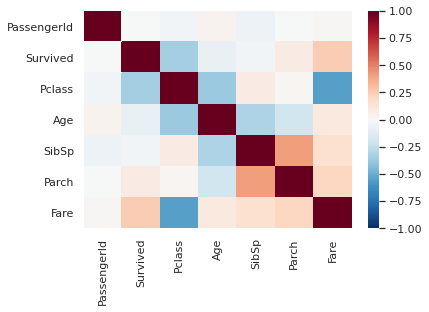

In [13]:
sns.heatmap(train.corr(), cmap="RdBu_r", vmax=1, vmin=-1)
plt.show()

The strongest correlations between the features are:
- `Pclass` and `Fare`
- `SibSp` and `Parch`

which make sense if we see what these features means.
<br>
<br>

In [14]:
train.corr()[['Survived']].drop('Survived')

,Survived
PassengerId,-0.005007
Pclass,-0.338481
Age,-0.077221
SibSp,-0.035322
Parch,0.081629
Fare,0.257307


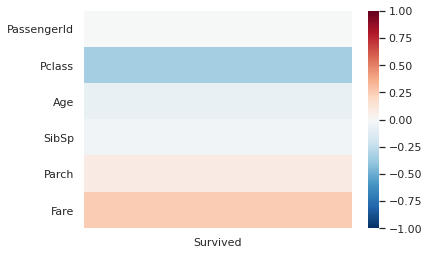

In [15]:
sns.heatmap(train.corr()[['Survived']].drop('Survived'), cmap="RdBu_r", vmax=1, vmin=-1)
plt.show()

- `Pclass` and `Fare` are the two feature more correlated with `Survived`.

### Bar chart for categorical features

In [16]:
def stacked_bar_chart_perc(feature: str):
    
    '''a percent stacked bar chart to analyse the percentage of each unique value
    in survided and not survived, given a train feature.'''
    
    survived_total = train[train.Survived==1]['PassengerId'].count()
    dead_total = train[train.Survived==0]['PassengerId'].count()
    
    survived_for_unique_value = train[train.Survived==1][feature].value_counts().sort_index()
    dead_for_unique_value = train[train.Survived==0][feature].value_counts().sort_index()
    
    survived = (survived_for_unique_value * 100) / survived_total
    dead = (dead_for_unique_value * 100) / dead_total
    
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    
    df.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Accent')

In [17]:
def stacked_bar_chart(df_normalized: pd.DataFrame, feature: str): 
    
    '''a stacked bar chart to analyse how many people survided or not 
    given a feature'''
    
    survived = df_normalized[df_normalized.Survived==1][feature]
    dead = df_normalized[df_normalized.Survived==0][feature]
    
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    
    ax = df.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Accent')
    ax.set_ylabel('Percentage of Passenger')

In [18]:
# feature normalization: get the percentage of each unique value from a feature.
# Example: I noticed most of the 3rd class is significantily present in both groups (survived or not). 
#          Is it because the quantity of people? Yes! So let's normalize these values and then compare them.

def normalize_feature(feature: str) -> pd.DataFrame:
    
    '''get a train feature and return a dataframe 'grouped' by 
    feature (index), survived, count and percentage (of each unique value 
    for survived or not).'''
    
    total = len(train['PassengerId'])
    
    df_normalized = train[[feature, 'Survived', 'PassengerId']].groupby([feature, 'Survived']).count()
    #df.apply(lambda row: round((row['PassengerId'] * 100 / total), 2), axis=1)
    df_normalized[feature+'_percentage'] = round((df_normalized['PassengerId'] * 100 / total), 2)
    
    return df_normalized.reset_index('Survived')

#### Sex

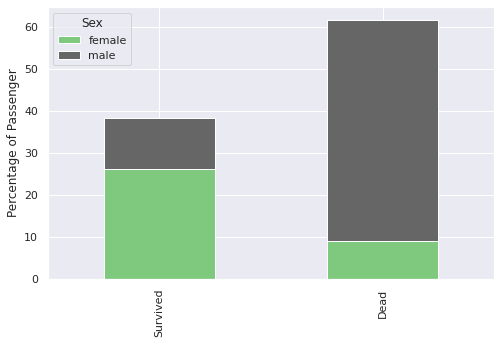

In [19]:
sex_normalized = normalize_feature('Sex')
stacked_bar_chart(sex_normalized, 'Sex_percentage')

- There are more men (>60%) than women. 
- But most of survivors were women. Women survived more than men. 
- And most of dead people were men. Men died more than women.

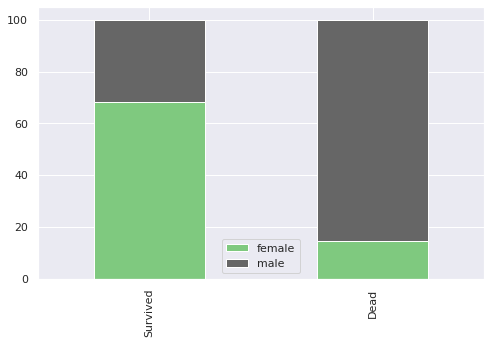

In [20]:
stacked_bar_chart_perc('Sex')

- From ~60% of male passengers, around 30% survived.
- From ~40% of female passengers, more than 65% survived.
<br>
<br>
- From ~40% of survived, almost 70% was female.
- From ~60% of dead, more than 80% was male.

#### Pclass

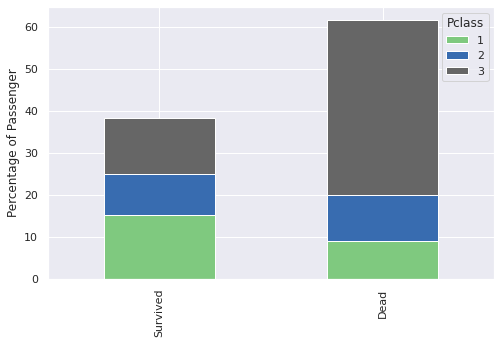

In [21]:
pclass_normalized = normalize_feature('Pclass')
stacked_bar_chart(pclass_normalized, 'Pclass_percentage')

- The 1st and 3rd class people survived more than 2 class.
- The 3rd class people died more than other classes.
<br>
<br>
- This graph has a normalized pclass. The percentagem of 3rd class is almost 50%.

**Observation** <br>
The 3rd class is significantily present in both groups. It happened because the quantity of people in 3rd class. <br>
Peharps it would be better to make this graph proportionally -- like: what percentage of first class survivors?

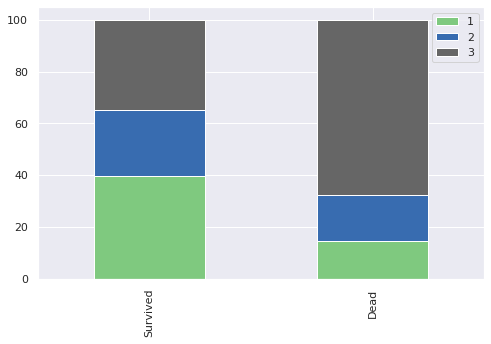

In [22]:
stacked_bar_chart_perc('Pclass')

- Through this graph we can see that almost 40% of survivors were from the 1st class.
- More than 20% of survivors were from 2nd class.
- And less than 40% of survivors were from 3rd class.
<br>
<br>
- From the ~50% of 3rd passengers, 40% survived.

#### SibSp

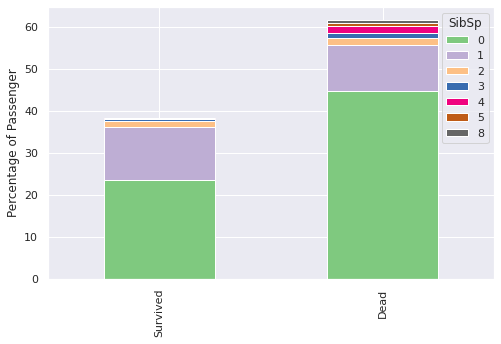

In [23]:
sibsp_normalized = normalize_feature('SibSp')
stacked_bar_chart(sibsp_normalized, 'SibSp_percentage')

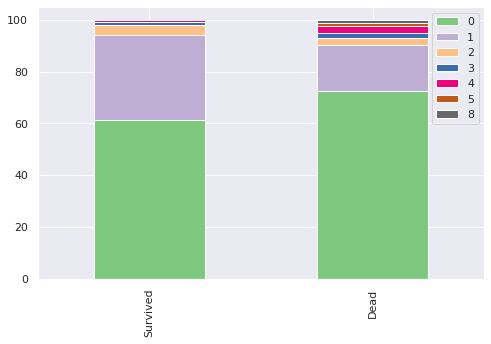

In [24]:
stacked_bar_chart_perc('SibSp')

#### Parch

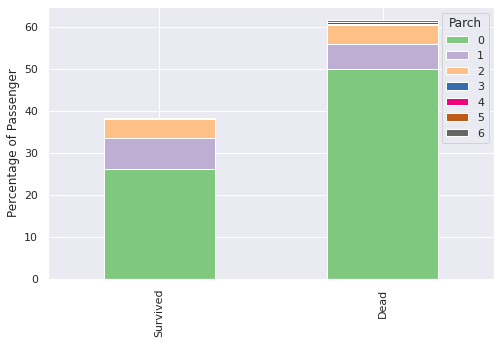

In [25]:
parch_normalized = normalize_feature('Parch')
stacked_bar_chart(parch_normalized, 'Parch_percentage')

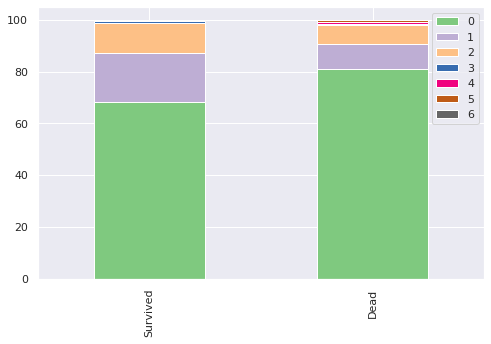

In [26]:
stacked_bar_chart_perc('Parch')

#### Embarked

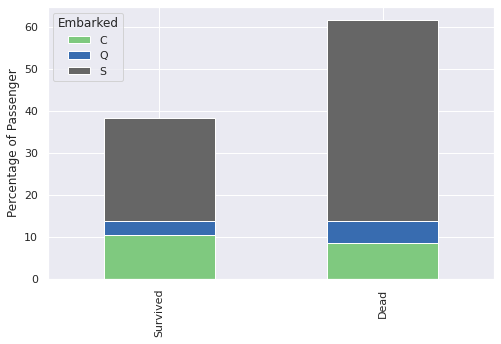

In [27]:
embarked_normalized = normalize_feature('Embarked')
stacked_bar_chart(embarked_normalized, 'Embarked_percentage')

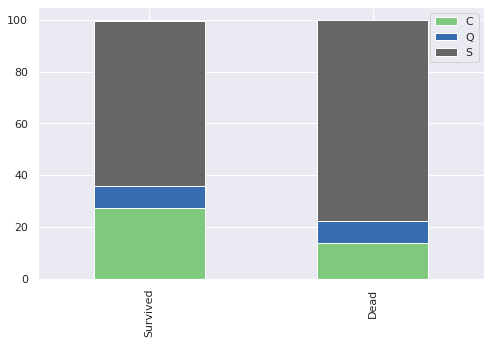

In [28]:
stacked_bar_chart_perc('Embarked')

# 5. Feature Engineering

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself ([wikipedia](https://en.wikipedia.org/wiki/Feature_engineering)). <br>
Algorithms in machine learning require a numerical representation of objects, because it facilitates the processing and statistical analysis. <br>
<br>
Examples
- Derive new features using existing features
- Remove irrelevant features (Feature Selection)
- Transform existing features
- Encoding categorical variables (Feature Encoding)
<br>

**Keep in mind the features with missing values: `Age`, `Cabin`, `Fare`, and `Embarked`**
<br>
<br>

In [29]:
all_data = [train, test]

### 5.1 Name (Honorifics: Mr, Miss, Mrs)

In [30]:
train[['Name']].tail()

,Name
886,"Montvila, Rev. Juozas"
887,"Graham, Miss. Margaret Edith"
888,"Johnston, Miss. Catherine Helen ""Carrie"""
889,"Behr, Mr. Karl Howell"
890,"Dooley, Mr. Patrick"


- How `Name` feature can be useful? <br>
If we get the information about Title, we can use it in `Age` missing values.

In [31]:
# get an expression beginning with a space + 1 or more letters + '.' in the end.
for dataset in all_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [32]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Lady          1
Mme           1
Ms            1
Countess      1
Don           1
Jonkheer      1
Sir           1
Capt          1
Name: Title, dtype: int64

In [33]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

- As we see most of people in train and test dataset are treated like`Mr`, `Miss` or `Mrs`.  So let's categorize them with numerical values...

But before do that, as we'll use it to fill age missing values, let's see where there are missing values in the datasets

In [34]:
train_age_nan = train[train.isnull()[['Age']].any(axis=1)]

(train_age_nan
     .groupby('Title')
     .count()[['PassengerId']]
     .sort_values('PassengerId', ascending=False))

,PassengerId
Title,
Mr,119
Miss,36
Mrs,17
Master,4
Dr,1


In [35]:
test_age_nan = test[test.isnull()[['Age']].any(axis=1)]

(test_age_nan
     .groupby('Title')
     .count()[['PassengerId']]
     .sort_values('PassengerId', ascending=False))

,PassengerId
Title,
Mr,57
Miss,14
Mrs,10
Master,4
Ms,1


- Most of them (missing age values) is part of the largest title groups.

### Converting `Title` to a numerical variable (categorical nominal)

**Title map** <br>
Mr : 0 <br>
Miss : 1 <br>
Mrs : 2 <br>
Others : 3

In [36]:
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 
                 'Master': 3, 'Dr': 3, 'Rev': 3, 'Col': 3, 'Major': 3,
                 'Mlle': 3, 'Countess': 3, 'Ms': 3, 'Lady': 3, 'Jonkheer': 3,
                 'Don': 3, 'Dona': 3, 'Mme': 3, 'Capt': 3, 'Sir': 3}

for dataset in all_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [37]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2


In [38]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2


In [39]:
train['Title'].value_counts()

0    517
1    182
2    125
3     67
Name: Title, dtype: int64

In [40]:
test['Title'].value_counts()

0    240
1     78
2     72
3     28
Name: Title, dtype: int64

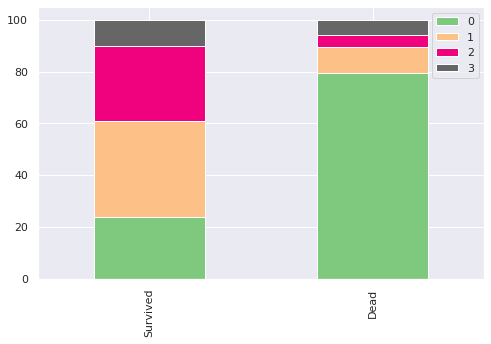

In [41]:
stacked_bar_chart_perc('Title')

- Most of suvivors have the `Miss` and `Mrs` title. (women)
- Most of the dead were treated like `Mr`. (men)

### Removing `Name` feature
they are no longer needed, because the `Title` is more important

In [42]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [43]:
train.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2


In [44]:
test.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,2


## 5.2 Sex

### Converting `Sex` to a numerical variable (categorical nominal)

**Sex map** <br>
male: 0 <br>
female: 1

In [45]:
sex_mapping = {'male': 0, 'female': 1}

for dataset in all_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

## 5.3 Age

### Handle with missing values

Decision: filling missing `Age` values with *median age* for each title (Mr, Mrs, Miss, Others)

- Concat all data to get a median for Age title. <br>
Why? Because we can get a better median from a larger and more diverse dataset. If we do it separately, as test is a smaller sample, the age median can be very different. <br>
OBS: when concat it, don't change the indexes, the real ones will be necessary to the next step. I'll use them to find the limit to filna on train and test datasets.

In [46]:
all_title_age_data = pd.concat([train[['Title', 'Age']], test[['Title', 'Age']]])

print(all_title_age_data.shape)
print(len(train) + len(test))

(1309, 2)
1309


In [47]:
all_title_age_data.tail(2)

,Title,Age
416,0,NaN
417,3,NaN


In [48]:
all_title_age_data[['Age']].head(10)

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
5,NaN
6,54.0
7,2.0
8,27.0
9,14.0


In [49]:
age_median = all_title_age_data.groupby('Title')['Age'].transform('median')

age_median.head(10)

0    29.0
1    35.5
2    22.0
3    35.5
4    29.0
5    29.0
6    29.0
7     9.0
8    35.5
9    35.5
Name: Age, dtype: float64

- Goal example: fill #5 (missing value) with 29.

In [50]:
train['Age'].fillna(age_median[:len(train)], inplace=True)
test['Age'].fillna(age_median[len(train):], inplace=True)

In [51]:
train[['Age']].head(6)

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
5,29.0


- #5 = 29

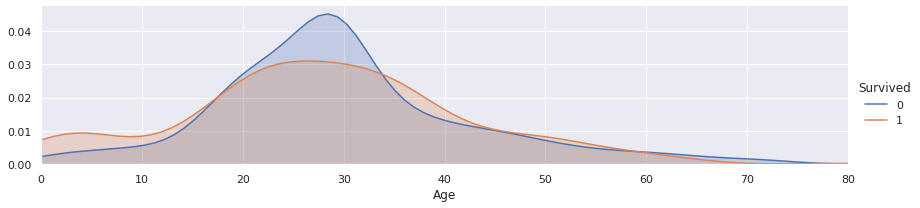

In [52]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)

facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.show()

**- Analysis:** <br>
There is no big difference between the age of most survivors and most of people who died. <br>
<br>
More people died than survived between ~ 17 and 33 yo. <br>
More people survived than died between 0 and 17 yo.

<br>
<br>

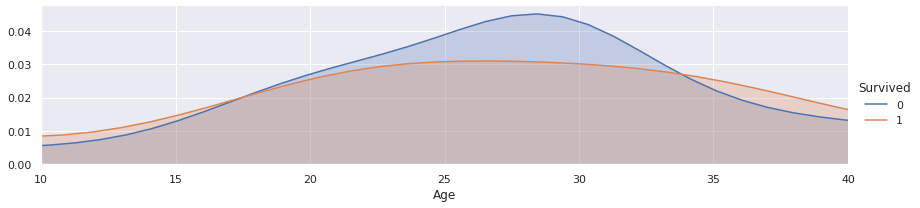

In [53]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)

facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.xlim(10, 40)
plt.show()

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          891 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 83.6+ KB


In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Title          418 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


- `Age` feature no longer has missing values.

### Converting Age to a numerical variable (categorical ordinal)

**Age map** <br>
child: 0 <br>
young: 1 <br>
adult: 2 <br>
mid-age: 3 <br>
senior: 4 <br>

In [56]:
for dataset in all_data:
    dataset.loc[(dataset['Age'] <= 16), 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[(dataset['Age'] > 62), 'Age'] = 4

In [57]:
train.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2


In [58]:
test.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,2.0,0,0,330911,7.8292,NaN,Q,0
1,893,3,1,3.0,1,0,363272,7.0000,NaN,S,2


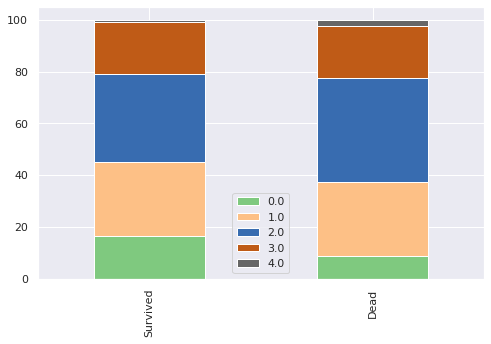

In [59]:
stacked_bar_chart_perc('Age')

In [60]:
train[train.Age == 4].groupby('Survived').count()[['PassengerId']]

,PassengerId
Survived,
0,12
1,3


In [61]:
train.groupby(['Age', 'Survived']).count()[['PassengerId']]

PassengerId
Age Survived             
0.0 0                  48
    1                  57
1.0 0                 158
    1                  97
2.0 0                 220
    1                 116
3.0 0                 111
    1                  69
4.0 0                  12
    1                   3

## 5.4 Embarked

### Handle with missing values

What is the most common Port of Embarkation? S! <br>
Decision: after see the most common port is 'S' in each Pclass and both datasets (train and test), filling missing embarked values with 'S'.

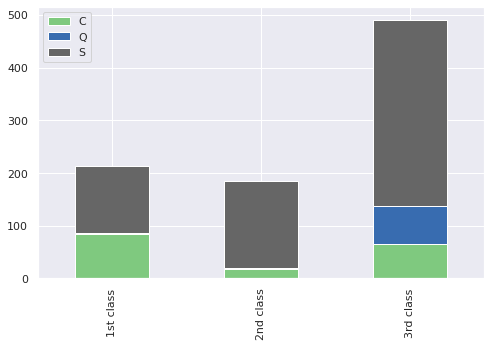

In [62]:
Pclass1 = train[train['Pclass']==1]['Embarked'].value_counts()
Pclass2 = train[train['Pclass']==2]['Embarked'].value_counts()
Pclass3 = train[train['Pclass']==3]['Embarked'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])

df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Accent')

plt.show()

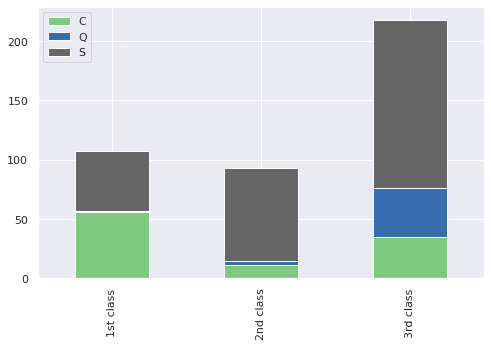

In [63]:
Pclass1 = test[test['Pclass']==1]['Embarked'].value_counts()
Pclass2 = test[test['Pclass']==2]['Embarked'].value_counts()
Pclass3 = test[test['Pclass']==3]['Embarked'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])

df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Accent')

plt.show()

- We can see that in test dataset the 1st class is 'balanced' between S and Q ports. However, if we join with train dataset, the 1st class will have S as the most used port.

In [64]:
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

### Converting Embarked to a numerical variable (categorical nominal)

**embarked map** <br>
S = 0 <br>
C = 1 <br>
Q = 2

In [65]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}

for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [66]:
train.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2


## 5.5 Fare

### Handle with missing values

Decision: filling missing Fare with the median Fare for each pclass.

In [67]:
all_pclass_fare = pd.concat([train[['Pclass', 'Fare']], test[['Pclass', 'Fare']]])
fare_median = all_pclass_fare.groupby('Pclass')['Fare'].transform('median')

In [68]:
train['Fare'].fillna(fare_median[:len(train)], inplace=True)
test['Fare'].fillna(fare_median[len(train):], inplace=True)

In [69]:
train.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2


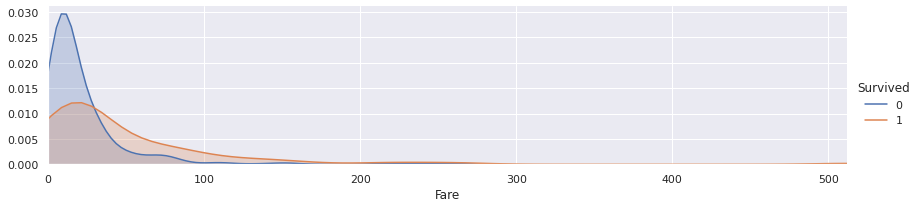

In [70]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)

facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()
 
plt.show()

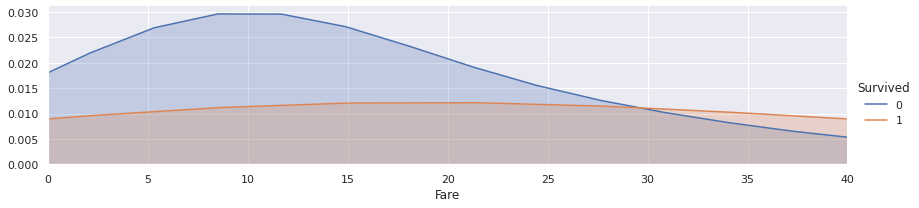

In [71]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)

facet.map(sns.kdeplot, 'Fare', shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.xlim(0, 40)
plt.show()

**- Analysis:** <br>
As we can see most of people who paid less than 30 died. <br>
On the other hand, most of people who paid more than 30 survived.
<br>
<br>

### Converting Fare to numerical variable (categorical ordinal)

In [72]:
for dataset in all_data:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

In [73]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,2.0,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,NaN,0,1
3,4,1,1,1,2.0,1,0,113803,2.0,C123,0,2
4,5,0,3,0,2.0,0,0,373450,0.0,NaN,0,0


## 5.6 Cabin

Understading the distribution

In [74]:
train.Cabin.value_counts().head()

C23 C25 C27    4
B96 B98        4
G6             4
F2             3
E101           3
Name: Cabin, dtype: int64

### Converting Cabin value to numerical values (categorical nominal)

Decision: consider the first Cabin letter.

In [75]:
for dataset in all_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

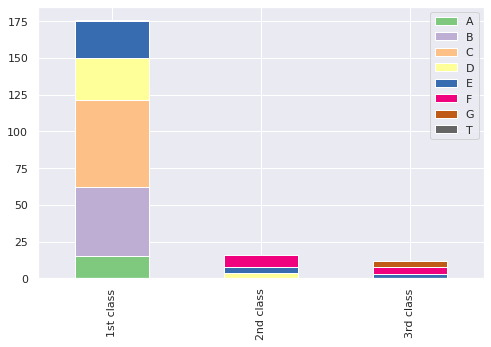

In [76]:
Pclass1 = train[train['Pclass']==1]['Cabin'].value_counts()
Pclass2 = train[train['Pclass']==2]['Cabin'].value_counts()
Pclass3 = train[train['Pclass']==3]['Cabin'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])

df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Accent')

plt.show()

In [77]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}

for dataset in all_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

### Handle with missing values

Decision: filling missing Cabin with the median Cabin for each pclass.

In [78]:
all_pclass_cabin = pd.concat([train[['Pclass', 'Cabin']], test[['Pclass', 'Cabin']]])
cabin_median = all_pclass_cabin.groupby('Pclass')['Cabin'].transform('median')

In [79]:
train['Cabin'].fillna(cabin_median[:len(train)], inplace=True)
test['Cabin'].fillna(cabin_median[len(train):], inplace=True)

In [80]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,2.0,0,0
1,2,1,1,1,3.0,1,0,PC 17599,2.0,0.8,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,2.0,0,1
3,4,1,1,1,2.0,1,0,113803,2.0,0.8,0,2
4,5,0,3,0,2.0,0,0,373450,0.0,2.0,0,0


In [81]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          418 non-null float64
Embarked       418 non-null int64
Title          418 non-null int64
dtypes: float64(3), int64(7), object(1)
memory usage: 36.0+ KB


## 5.7 Family Size

New feature

In [82]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

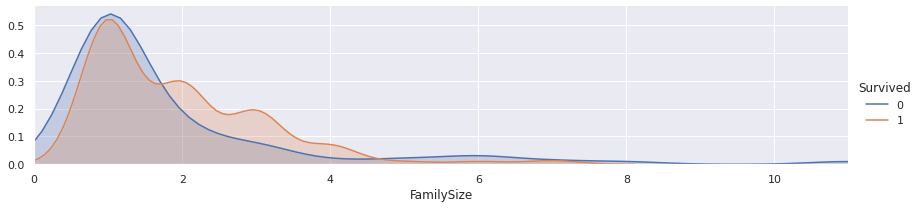

In [83]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)

facet.map(sns.kdeplot, 'FamilySize', shade=True)
facet.set(xlim=(0, train['FamilySize'].max()))
facet.add_legend()

plt.xlim(0)
plt.show()

**- Analysis:** <br>
Most of people with family size less than 2 or bigger than 5 died. <br>
Most of people with family size between 2 and 4 survived. 
<br>
<br>

### Categorizing the Family feature (categorical ordinal)

In [84]:
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}

for dataset in all_data:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

In [85]:
train.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,2.0,0,0,0.4
1,2,1,1,1,3.0,1,0,PC 17599,2.0,0.8,1,2,0.4


In [86]:
test.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,2.0,0,0,330911,0.0,2.0,2,0,0.0
1,893,3,1,3.0,1,0,363272,0.0,2.0,0,2,0.4


## 5.8 Removing unnecessary features

In [87]:
features_drop = ['Ticket', 'SibSp', 'Parch']

train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

## 5.9 Creating train_data, test_data, and target dataframes

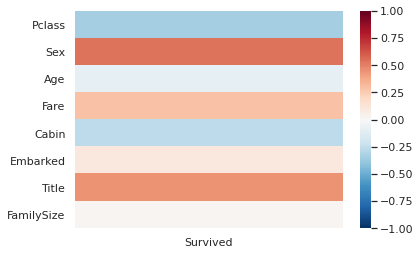

In [88]:
sns.heatmap(train.corr()[['Survived']].drop('Survived'), cmap="RdBu_r", vmax=1, vmin=-1)

In [89]:
train_data = train.drop('Survived', axis=1)
target = train['Survived']

train_data.shape, target.shape

((891, 8), (891,))

In [90]:
train_data.head(2)

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,3.0,2.0,0.8,1,2,0.4


In [91]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null float64
Fare          891 non-null float64
Cabin         891 non-null float64
Embarked      891 non-null int64
Title         891 non-null int64
FamilySize    891 non-null float64
dtypes: float64(4), int64(4)
memory usage: 55.8 KB


In [92]:
target.head(2)

0    0
1    1
Name: Survived, dtype: int64

In [93]:
test_data = test.drop('PassengerId', axis=1).copy()

In [94]:
test_data.head(2)

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,2.0,0.0,2.0,2,0,0.0
1,3,1,3.0,0.0,2.0,0,2,0.4


In [95]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass        418 non-null int64
Sex           418 non-null int64
Age           418 non-null float64
Fare          418 non-null float64
Cabin         418 non-null float64
Embarked      418 non-null int64
Title         418 non-null int64
FamilySize    418 non-null float64
dtypes: float64(4), int64(4)
memory usage: 26.2 KB


# 6. Modeling

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import auc, roc_curve, precision_recall_curve

import numpy as np

In [97]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null float64
Fare          891 non-null float64
Cabin         891 non-null float64
Embarked      891 non-null int64
Title         891 non-null int64
FamilySize    891 non-null float64
dtypes: float64(4), int64(4)
memory usage: 55.8 KB


- No missing values 
<br>
<br>

just keep in mind: <br>
- TPR = Recall = TP / (TP + FN)
- FPR = FP / (FP + TN)

- Recall : What proportion of actual positives was identified correctly?
- Precision : What proportion of positive identifications was actually correct?

In [98]:
def area_under_curve_graph (true_positive_rate, false_positive_rate): 
    
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize = (6,6))
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, true_positive_rate, color = 'green', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [99]:
def prediction_recall_curve_graph (recall, precision, thresholds):
    
    pr_auc = auc(recall, precision)
        
    plt.figure(figsize = (6,6))
    plt.title('Precision Recall Curve')
    plt.plot(recall, precision, color = 'red', label = 'PR AUC = %0.2f' % pr_auc)
    plt.legend(loc = 'lower right')

    # no_skill = Count of P / Total count
    no_skill = len(target[target==1]) / len(target)
    plt.plot([0, 1],  [no_skill, no_skill], linestyle = '--')

    # Get best threshold
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

    plt.plot(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.axis('tight')
    plt.ylabel('Precision')
    plt.xlabel('Recall')

## 6.1 Cross Validation (k-fold)

In [100]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [101]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## 6.2 KNN

In [102]:
clf_knn = KNeighborsClassifier(n_neighbors=13)
scoring = 'accuracy'
score = cross_val_score(clf_knn, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.81111111 0.76404494 0.82022472 0.83146067 0.85393258 0.80898876
 0.85393258 0.78651685 0.84269663 0.82022472]


In [103]:
round(np.mean(score)*100,2)

81.93

In [104]:
y_pred_prob_knn = cross_val_predict(clf_knn, train_data, target, 
                                    cv=k_fold, n_jobs=1, method='predict_proba')

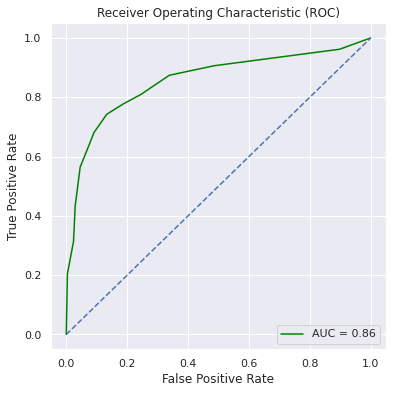

In [105]:
false_positive_rate_knn, true_positive_rate_knn, threshold_knn = roc_curve(target, y_pred_prob_knn[:,1])

area_under_curve_graph(true_positive_rate_knn, false_positive_rate_knn)

Best Threshold=0.538462, F-Score=0.759


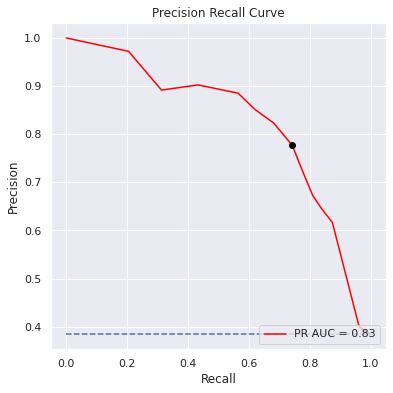

In [106]:
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(target, y_pred_prob_knn[:,1])

prediction_recall_curve_graph(recall_knn, precision_knn, thresholds_knn)

## 6.3 Decision tree

In [107]:
clf_dt = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf_dt, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.76666667 0.83146067 0.7752809  0.7752809  0.87640449 0.78651685
 0.82022472 0.82022472 0.74157303 0.80898876]


In [108]:
round(np.mean(score)*100,2)

80.03

In [109]:
y_pred_prob_dt = cross_val_predict(clf_dt, train_data, target, 
                                   cv=k_fold, n_jobs=1, method='predict_proba')

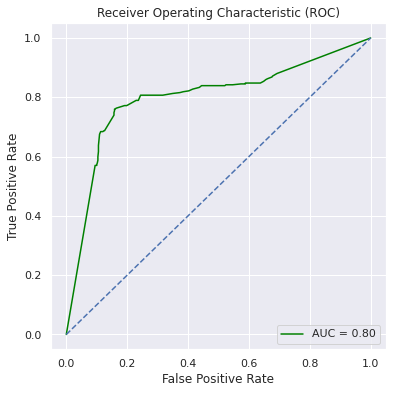

In [110]:
false_positive_rate_dt, true_positive_rate_dt, threshold_dt = roc_curve(target, y_pred_prob_dt[:,1])

area_under_curve_graph(true_positive_rate_dt, false_positive_rate_dt)

Best Threshold=0.437500, F-Score=0.755


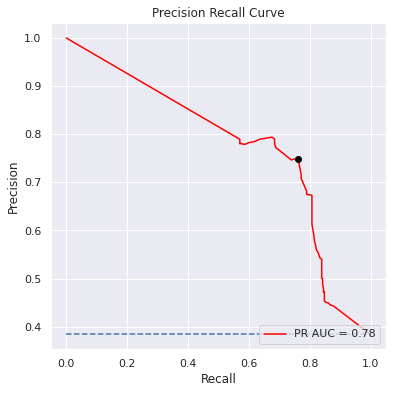

In [111]:
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(target, y_pred_prob_dt[:,1])

prediction_recall_curve_graph(recall_dt, precision_dt, thresholds_dt)

## 6.4 Random Forest

In [112]:
clf_rf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf_rf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.76666667 0.83146067 0.80898876 0.79775281 0.86516854 0.82022472
 0.80898876 0.82022472 0.79775281 0.80898876]


In [113]:
round(np.mean(score)*100,2)

81.26

In [114]:
y_pred_prob_rf = cross_val_predict(clf_rf, train_data, target, 
                                   cv=k_fold, n_jobs=1, method='predict_proba')

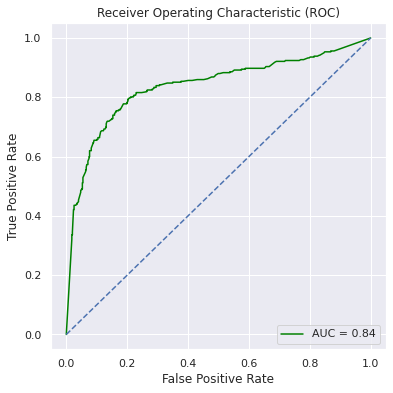

In [115]:
false_positive_rate_rf, true_positive_rate_rf, threshold_rf = roc_curve(target, y_pred_prob_rf[:,1])

area_under_curve_graph(true_positive_rate_rf, false_positive_rate_rf)

Best Threshold=0.314103, F-Score=0.749


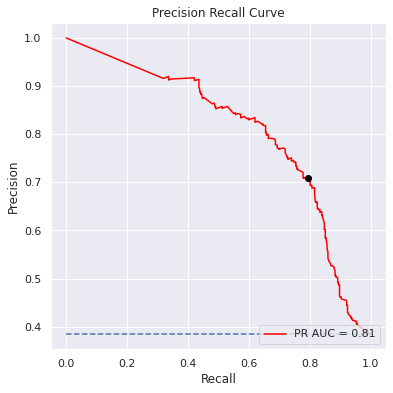

In [116]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(target, y_pred_prob_rf[:,1])

prediction_recall_curve_graph(recall_rf, precision_rf, thresholds_rf)

## 6.5 Naive Bayes

In [117]:
clf_gnb = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf_gnb, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.85555556 0.73033708 0.75280899 0.75280899 0.70786517 0.80898876
 0.76404494 0.79775281 0.86516854 0.83146067]


In [118]:
round(np.mean(score)*100, 2)

78.67

In [119]:
y_pred_prob_gnb = cross_val_predict(clf_gnb, train_data, target, 
                                    cv=k_fold, n_jobs=1, method='predict_proba')

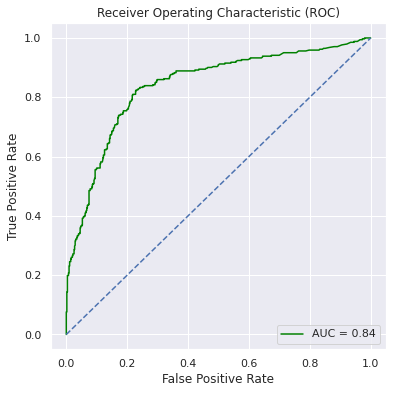

In [120]:
false_positive_rate_gnb, true_positive_rate_gnb, threshold_gnb = roc_curve(target, y_pred_prob_gnb[:,1])

area_under_curve_graph(true_positive_rate_gnb, false_positive_rate_gnb)

Best Threshold=0.531259, F-Score=0.752


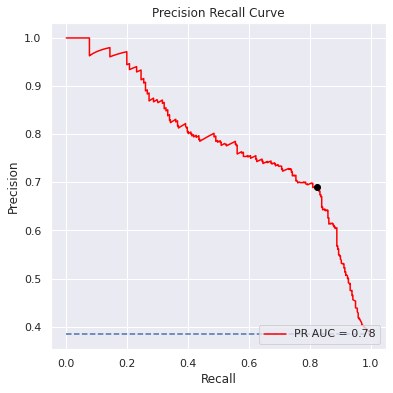

In [121]:
precision_gnb, recall_gnb, thresholds_gnb = precision_recall_curve(target, y_pred_prob_gnb[:,1])

prediction_recall_curve_graph(recall_gnb, precision_gnb, thresholds_gnb)

## 6.6 SVM

In [122]:
clf_svc = SVC(gamma='scale')
scoring = 'accuracy'
score = cross_val_score(clf_svc, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.83333333 0.79775281 0.83146067 0.82022472 0.84269663 0.82022472
 0.84269663 0.85393258 0.84269663 0.86516854]


In [123]:
round(np.mean(score)*100,2)

83.5

In [124]:
clf_svc_t = SVC(gamma='scale', probability=True)

y_pred_prob_svc = cross_val_predict(clf_svc_t, train_data, target,
                                    cv=k_fold, n_jobs=1, method='predict_proba')

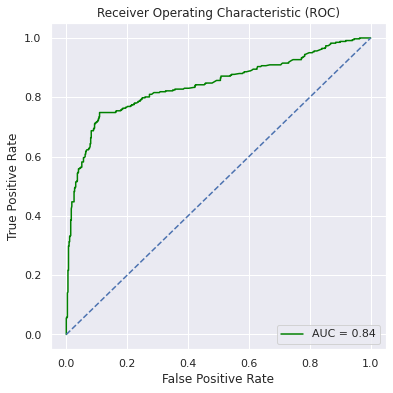

In [125]:
false_positive_rate_svc, true_positive_rate_svc, threshold_svc = roc_curve(target, y_pred_prob_svc[:,1])

area_under_curve_graph(true_positive_rate_svc, false_positive_rate_svc)

Best Threshold=0.494929, F-Score=0.778


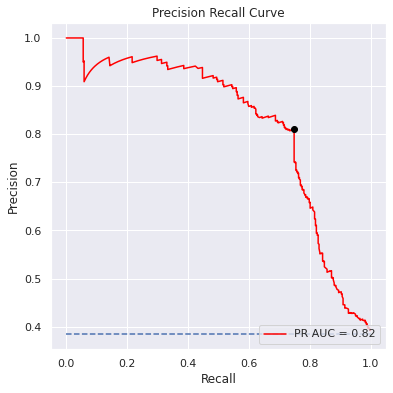

In [126]:
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(target, y_pred_prob_svc[:,1])

prediction_recall_curve_graph(recall_svc, precision_svc, thresholds_svc)

# 7. Applying the best algorithm SVM or KNN

for this case SVM was the algorithm with the best accuracy
and KNN have the best AUC

In [127]:
clf = SVC(gamma='scale')
clf.fit(train_data, target)

prediction = clf.predict(test_data)

In [128]:
## Kaggle challenge ask for passengerID and Survived

result = pd.DataFrame({'PassengerId': test['PassengerId'],
                      'Survived': prediction})

result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
